# Practical Usage - Intel Corporation (INTC) Stock Analysis

In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import xgboost as xgb

from copy import deepcopy as dc
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/intc_stock_history.csv", index_col="Date", parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.182651,10924800
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.181190,17068800
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.185573,18508800
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.184843,11174400
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.178267,12172800


In [4]:
df.columns = [col.lower() for col in df]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11189 entries, 1980-03-17 to 2024-08-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       11189 non-null  float64
 1   high       11189 non-null  float64
 2   low        11189 non-null  float64
 3   close      11189 non-null  float64
 4   adj close  11189 non-null  float64
 5   volume     11189 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 611.9 KB


In [6]:
df.describe()

,open,high,low,close,adj close,volume
count,11189.000000,11189.000000,11189.000000,11189.000000,11189.000000,1.118900e+04
mean,20.324258,20.602362,20.048154,20.323275,15.018844,5.038398e+07
std,17.513803,17.756197,17.277062,17.513189,14.853241,3.460649e+07
min,0.218750,0.218750,0.216146,0.216146,0.121280,0.000000e+00
25%,1.421875,1.445313,1.390625,1.421875,0.797820,2.731200e+07
50%,20.687500,20.950001,20.437500,20.690001,12.745426,4.432000e+07
75%,31.049999,31.480000,30.559999,31.062500,22.642534,6.432000e+07
max,75.625000,75.828125,73.625000,74.875000,62.477169,5.677088e+08


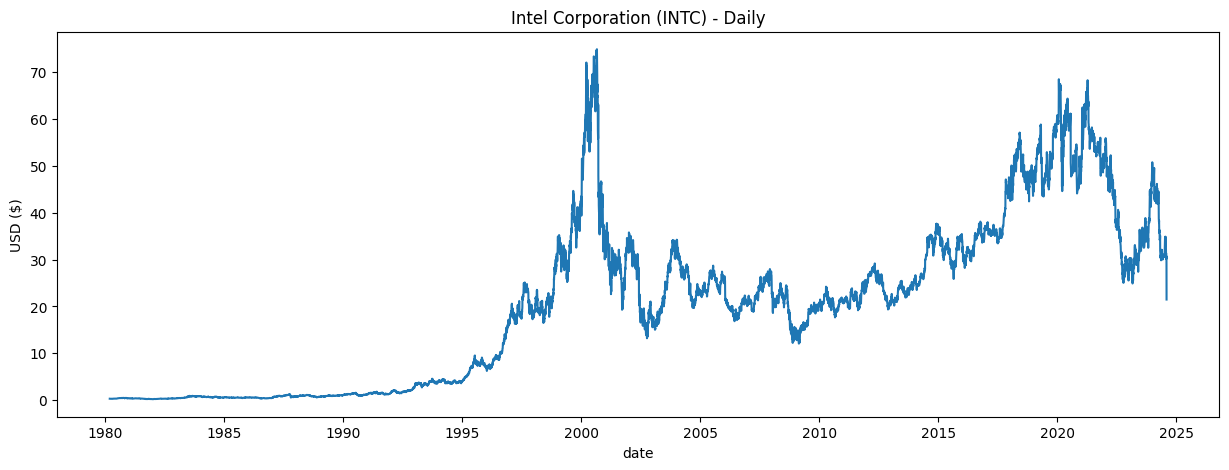

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Intel Corporation (INTC) - Daily")

ax.plot(df.close)
ax.set_xlabel("date")
ax.set_ylabel("USD ($)")
plt.show()

In [8]:
df.insert(0, 'month', [date.strftime("%Y-%m") for date in df.index])
df.insert(0, 'year', [date.strftime("%Y") for date in df.index])


In [9]:
df_year = df.groupby("year").agg({"open": "min", "high":"max", "low":"min", "close":"mean", "adj close": "mean", "volume": "sum"})

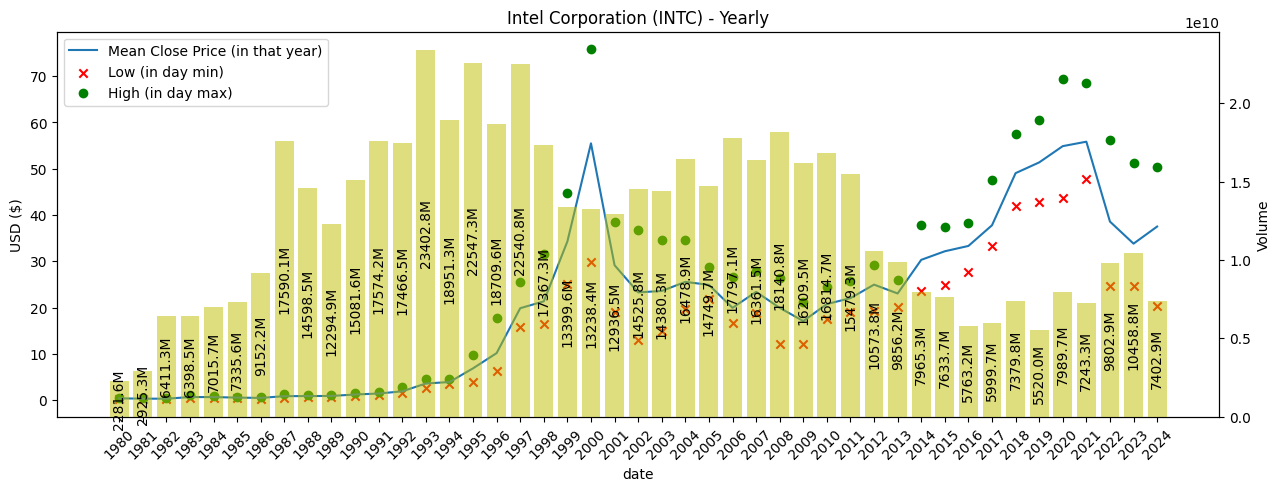

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Intel Corporation (INTC) - Yearly")
mean_close_price = ax.plot(df_year.close, label="Mean Close Price (in that year)")

low_per_year = ax.scatter(df_year.index, df_year.low, color="r", marker="x", label="Low (in day min)")
high_per_year = ax.scatter(df_year.index, df_year.high, color="g", marker="o", label="High (in day max)")

ax.set_xlabel("date")
ax.set_ylabel("USD ($)")
plt.xticks(rotation=45)

ax2 = ax.twinx()
bar_chart = ax2.bar(df_year.index, df_year.volume, color="y", label="Volume", alpha=0.5)


labels = [f'{val * 1e-6:.1f}M' for val in df_year['volume']]
ax2.bar_label(bar_chart, labels=labels, rotation=90, label_type="center", )
ax2.set_ylabel("Volume")


ax.legend()
plt.show()

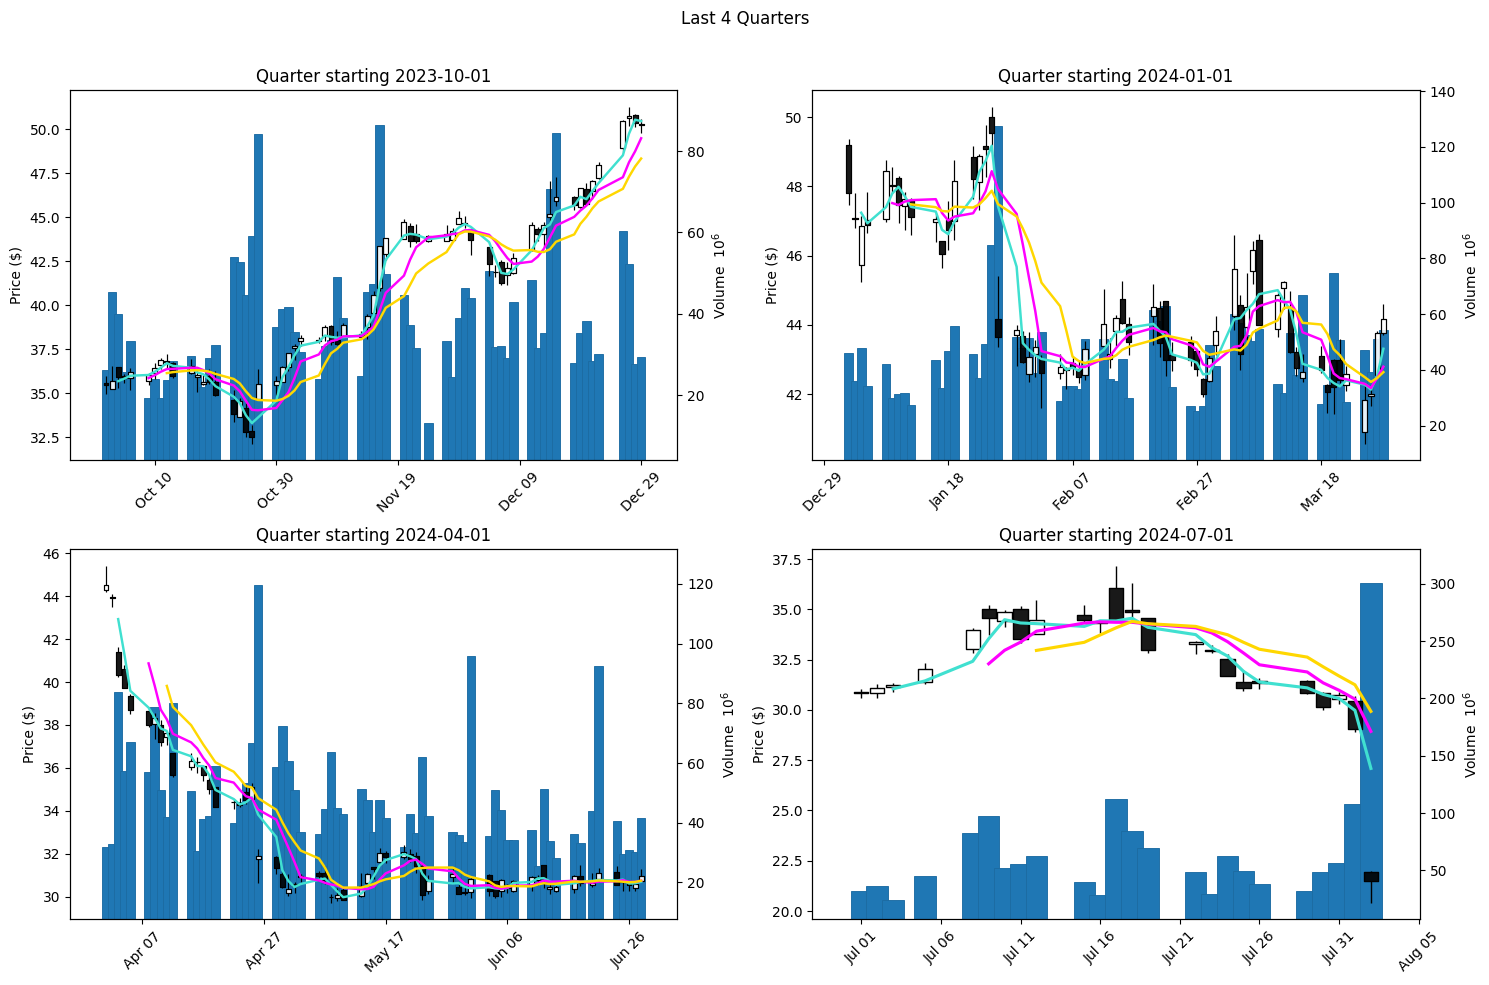

In [11]:
start_date = "2023-09-01"
quarters =  pd.date_range(start=start_date, periods=4, freq='3ME')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Last 4 Quarters")

for i, ax in enumerate(axs.flatten()):
    start_q = quarters[i] + pd.Timedelta(days=1)

    if start_q == pd.to_datetime("2024-07-01"):
        df_quarter = df[start_q:]

    else:
        end_q = quarters[i + 1]
        df_quarter = df[start_q:end_q]

    ax_volume = ax.twinx()
    ax_volume.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    mpf.plot(df_quarter, type='candle', mav=(3, 6, 9), ax=ax, volume=ax_volume, show_nontrading=True, ylabel="Price ($)")
    ax.set_title(f'Quarter starting {start_q.date()}')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

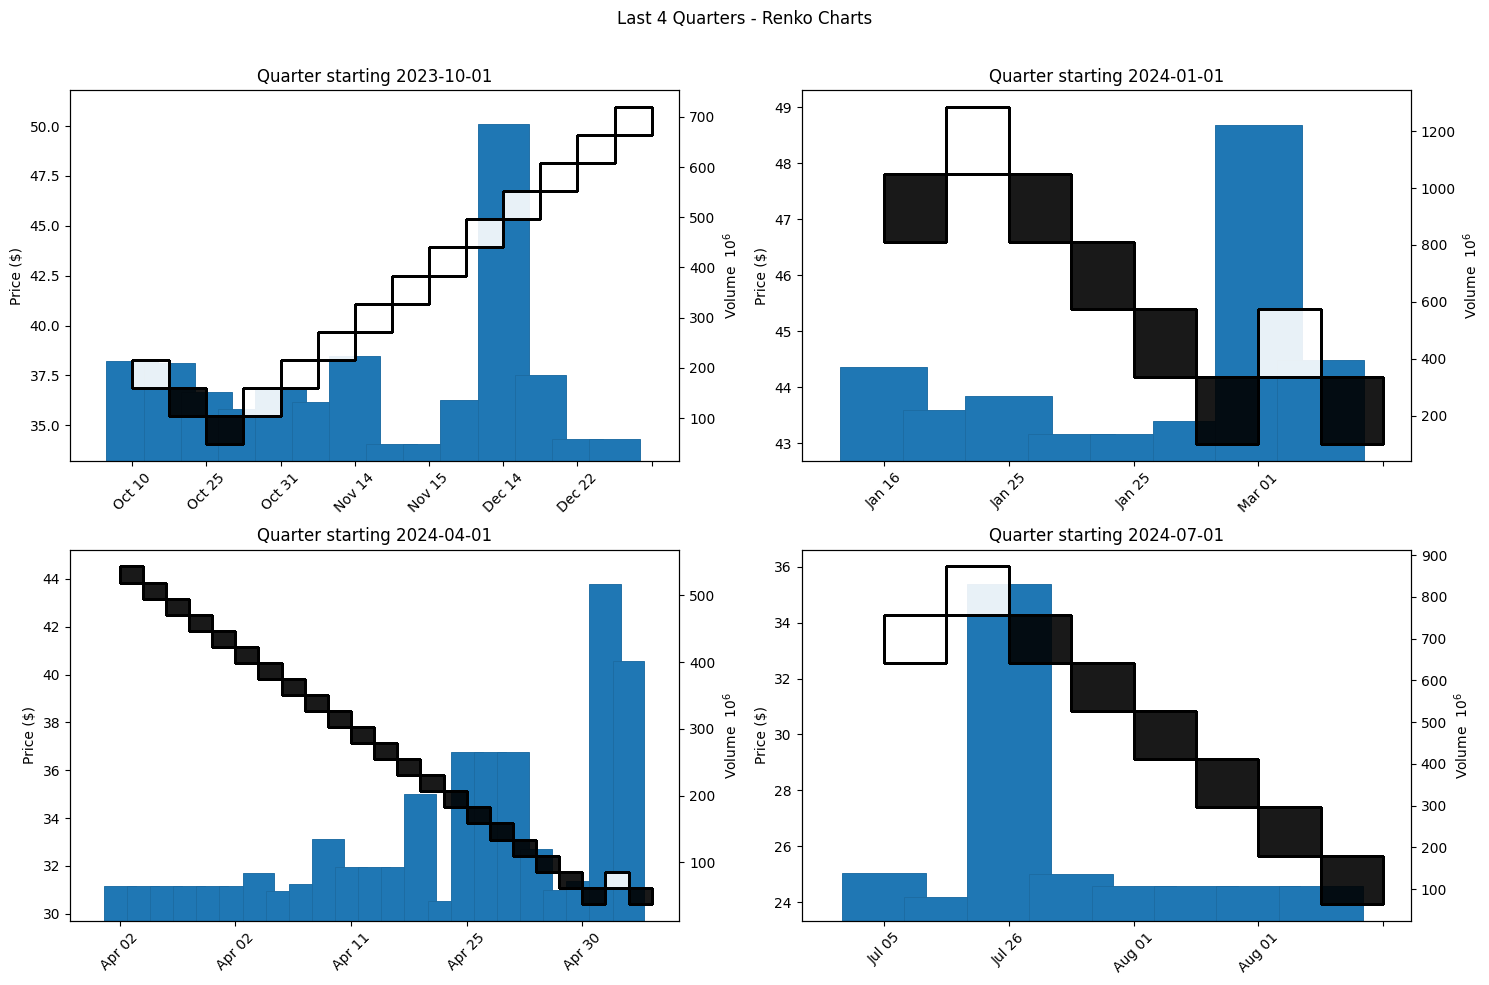

In [12]:
start_date = "2023-09-01"
quarters =  pd.date_range(start=start_date, periods=4, freq='3ME')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Last 4 Quarters - Renko Charts")

for i, ax in enumerate(axs.flatten()):
    start_q = quarters[i] + pd.Timedelta(days=1)

    if start_q == pd.to_datetime("2024-07-01"):
        df_quarter = df[start_q:]

    else:
        end_q = quarters[i + 1]
        df_quarter = df[start_q:end_q]

    ax_volume = ax.twinx()
    ax_volume.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    mpf.plot(df_quarter, type='renko', ax=ax, volume=ax_volume, show_nontrading=True, ylabel="Price ($)")
    ax.set_title(f'Quarter starting {start_q.date()}')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Prediction with XGBRegressor

### Next Day Price based on past Open, High, Low, Close, Volume

In [13]:
df.drop(["year", "month", "adj close"], axis=1, inplace=True)

In [14]:
df.tail()

,open,high,low,close,volume
Date,,,,,
2024-07-29,31.420000,31.469999,30.790001,30.830000,32342200
2024-07-30,30.850000,30.910000,30.010000,30.129999,48256600
2024-07-31,30.540001,30.870001,30.280001,30.740000,56110600
2024-08-01,30.430000,30.709999,28.889999,29.049999,107672500
2024-08-02,21.940001,21.980000,20.420000,21.480000,300282800


In [15]:
df_stationary = np.log(df).diff()
df_stationary.dropna(inplace=True)
df_stationary = df_stationary[[col for col in df_stationary if col != "close"] + ["close"]]

c:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [16]:
def is_stationary(timeseries):
    """
    Determines if a time series is stationary using the Augmented Dickey-Fuller (ADF) test.

    Returns:
    bool: True if the time series is stationary, False otherwise.
    """

    adf_result = adfuller(timeseries)
    test_statistic = adf_result[0]
    critical_values = adf_result[4]
    df_output = pd.Series(adf_result[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in adf_result[4].items():
        df_output["Critical Value (%s)"%key] = value
        
    if test_statistic < critical_values['5%']:  ## 5% significance level
        print(True)
    else:
        print(False)


In [17]:
df_stationary.replace([np.inf, -np.inf], np.nan, inplace=True)

In [18]:
df_stationary.volume = df_stationary.volume.interpolate()

In [19]:
df_stationary.isna().sum()

open      0
high      0
low       0
volume    0
close     0
dtype: int64

In [20]:
for col in df_stationary:
    is_stationary(df_stationary.loc[:, col])

True
True
True
True
True


In [21]:
def create_past_features(dataframe, predicted_column, n_past=int):

    df_shifted = dc(dataframe)
    
    features = df_shifted.columns.to_list()
    
    for feature in features:
        for i in range(1, n_past + 1):
            df_shifted[f"{feature}_(t-{i})"] = df_shifted[feature].shift(i)

    features.remove(predicted_column)
    df_shifted.drop(features, axis=1, inplace=True)

    df_shifted = df_shifted[[col for col in df_shifted if col != predicted_column] + [predicted_column]]
    
    df_shifted.dropna(inplace=True)
    return df_shifted   

In [22]:
tscv = TimeSeriesSplit(n_splits=2000, test_size=1, gap=0)  # Number of splits, test_size=1 (1 day prediction),  gap=1 

In [23]:
predictions = []
true_values = []
i = 0

for train_index, test_index in tscv.split(df_stationary):

    model = xgb.XGBRegressor()

    train = df_stationary.iloc[train_index]
    test = df_stationary.iloc[[test_index-7][0][0]:test_index[0]+1]

    if i == 0:
        first_test_date = test.index[-1]
        i += 1
        
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

    train_shifted = create_past_features(train_scaled, "close", n_past=7)
    test_shifted = create_past_features(test_scaled, "close", n_past=7)


    train_X, train_y = train_shifted.iloc[:, :-1], train_shifted.iloc[:, -1]
    test_X, test_y = test_shifted.iloc[:, :-1], test_shifted.iloc[:, -1]

    model.fit(train_X, train_y)
    
    y_pred = model.predict(test_X)

    y_pred_unscaled = scaler.inverse_transform(np.concatenate([np.ones((1, len(test.columns)-1)), y_pred.reshape(1, -1)], axis=1))[:, -1][0]

    y_pred_exp = np.exp(np.log(df.loc[test.index[-2]].close) + y_pred_unscaled)
    y_true = df.loc[test.index[-1]].close

    predictions.append(y_pred_exp)
    true_values.append(y_true)

    print(train.index[-1], flush=True, end="\r")
    
    del model, scaler

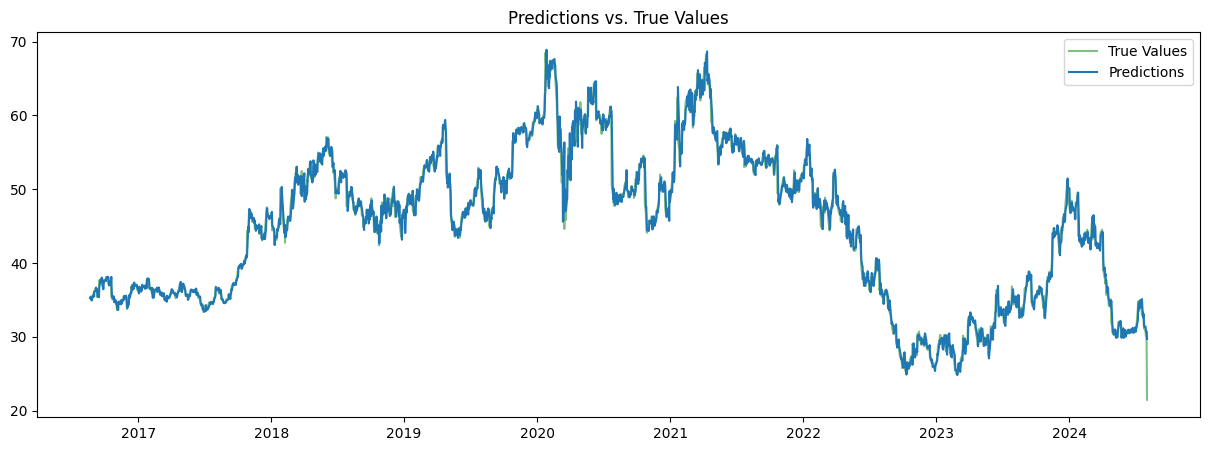

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Predictions vs. True Values")
#ax.plot(df[first_test_date:].index, true_values, label="True Values Test")
ax.plot(df[first_test_date:].index, df[first_test_date:].close, color="g", label="True Values", alpha=0.5)
ax.plot(df[first_test_date:].index, predictions, label="Predictions")

ax.legend()
plt.show()

In [25]:
mean_squared_error(true_values, predictions)

1.2483956674418957

In [26]:
mean_squared_error(true_values, predictions, squared=False)

1.1173162790552618

In [27]:
mean_absolute_error(true_values, predictions)

0.7197511560279312

In [28]:
mean_absolute_percentage_error(true_values, predictions)

0.016091357967814038

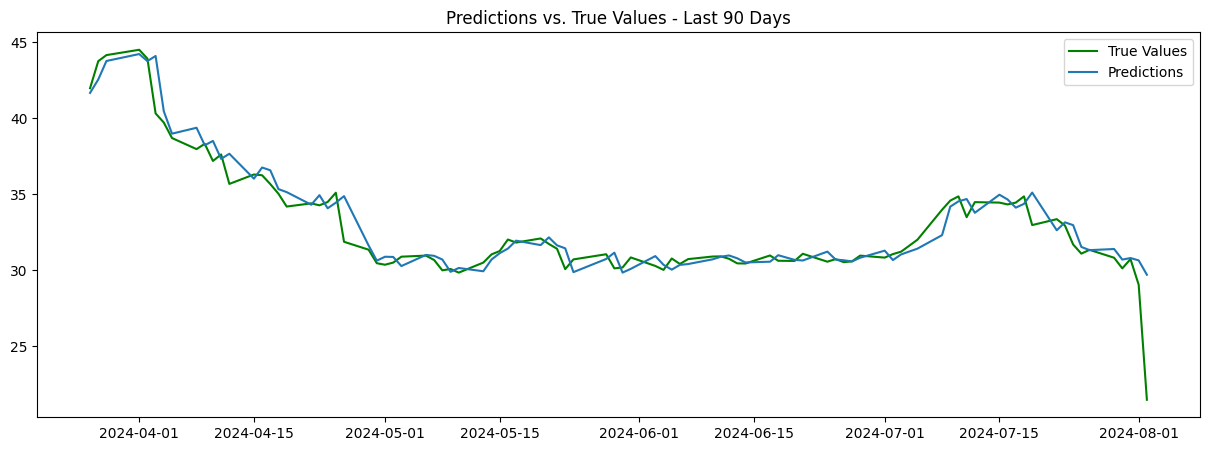

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Predictions vs. True Values - Last 90 Days")
#ax.plot(df[first_test_date:].index, true_values, label="True Values Test")
ax.plot(df.iloc[-90:].index, df.iloc[-90:].close, color="g", label="True Values")
ax.plot(df.iloc[-90:].index, predictions[-90:], label="Predictions")

ax.legend()
plt.show()